<a href="https://colab.research.google.com/github/arthurpeter/Machine_Learning/blob/main/GradCAM_FeatureVisualization_Skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Ascent

<br>

Diferența dintre **Gradient Ascent** și **Gradient Descent** constă în semn. **Gradient Ascent** înseamnă modificarea parametrilor conform direcției gradientului funcției (și, prin urmare, creșterea valorii acesteia). În schimb, **Gradient Descent** implică deplasarea în sens opus gradientului (și astfel scăderea valorii funcției).

Când antrenăm o rețea (optimizând o funcție obiectiv), nu dorim să creștem loss-ul, ci dimpotrivă. Acesta este motivul pentru care folosim **Gradient Descent**. Totuși, dacă dorim să maximizăm activările unei rețele, atunci **Gradient Ascent** este abordarea dorită.


$$
    \text{Gradient Ascent on} \; (f) = \text{Gradient Descent on} \; (-f)
$$

<br>

<div align="center">
  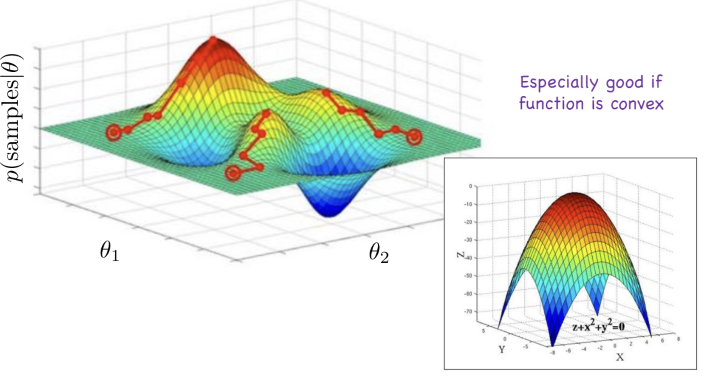
</div>

# Vizualizarea Canalelor

Pentru a încerca să înțelegem ce "vede" o rețea într-o imagine, o idee ar fi să inspectăm tipurile de intrări care provoacă un răspuns puternic (ca magnitudine a activărilor neuronilor). O metodă destul de simplă ar fi să folosim imagini din setul de antrenament și să verificăm, în fiecare caz, ce imagini (sau părți ale imaginilor) generează activări mai mari. Totuși, o abordare mai direcționată, prezentată în acest notebook, este să construim intrări exact în acest scop (folosind **Gradient Ascent**). Procesul este următorul:


1. Inițializarea parametrilor (valorile input-ului antrenat)
2. Executarea pasului forward
3. Calcularea gradientului

4. Actualizarea parametrilor

$$
  \large \theta_{new} = \theta_{old} + \alpha \nabla_{\theta} J(\theta)
$$

5. Repetarea pentru un număr dat de epoci

In [ ]:
from typing import Tuple, Optional, List, Dict
from torchvision import transforms
from tqdm.auto import tqdm
from pathlib import Path
from torch import Tensor
from PIL import Image

import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torchvision
import random
import torch
import cv2

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Funcții auxiliare (normalizare și scalare a imaginilor)

In [ ]:
mean = torch.tensor((0.485, 0.456, 0.406), device=device).view(1, -1, 1, 1)
std  = torch.tensor((0.229, 0.224, 0.225), device=device).view(1, -1, 1, 1)

In [ ]:
def norm(x: Tensor) -> Tensor:
    """Normalize a Tensor with Imagenet statistics"""
    return (x - mean) / std

In [ ]:
def deprocess_image(image: Tensor) -> np.ndarray:
    image = image.clone().detach()[0]
    image -= image.mean()
    image /= (image.std() + 1e-5)
    image *= 0.1

    image = image.permute(1, 2, 0).cpu().numpy()
    image += 0.5
    image = np.clip(image, 0, 1)

    image *= 255
    image = np.clip(image, 0, 255).astype('uint8')
    return image

In [ ]:
def normalize_L2(x: Tensor) -> Tensor:
    """Normalize a Tensor by its L2 norm"""
    return x / (torch.sqrt(torch.mean(torch.square(x))) + 1e-5)

## Încărcarea modelului - VGG16 pre-antrenat

In [ ]:
model = torchvision.models.vgg16_bn(weights='DEFAULT')

model = model.to(device)
model = model.eval()

target_layer = model.features[-1]

## Selectarea straturilor pentru vizualizare

In [ ]:
layer_names = ['features.3', 'features.10', 'features.24']
alpha, n = 1., 4

## Salvarea activărilor folosind Hook-uri

Un **hook** în PyTorch este o funcție care permite înregistrarea unui callback pe un tensor specific pentru a efectua diferite acțiuni în timpul pașilor de forward sau backward ai unei rețele neurale. Pentru construirea vizualizării, vom folosi un hook pe stratul țintă pentru a salva activările acestuia.

In [ ]:
activations = {}

def save_activations(name):

    def hook(module, input, output):
        activations[name] = output

    return hook

## Construirea vizualizărilor

In [ ]:
%%time

kept_filters = dict()

for layer_name in tqdm(layer_names, leave=False):

    filters = []

    # Find the layer we want to hook (knowing  its name)
    hook = None
    for name, module in model.named_modules():
        if name == layer_name:
            hook = module.register_forward_hook(save_activations(name))
            break

    for filter_index in range(64):  # Only considering the first 64 channels
        x = torch.rand(1, 3, 128, 128)
        x = x.to(device)

        for i in range(15):  # Training for 15 epochs
            x = x.requires_grad_()
            model(norm(x))

            ### TODO: Implement the Gradient Ascent Step ###

            # TODO 1: Compute the loss - mean activation of the target layer
            # using the current `filter_index`
            loss = -torch.mean(activations[layer_name][:, filter_index])

            # TODO 2: Compute the gradients (call .backward())
            loss.backward()

            # TODO 3: Change the input in the direction of the gradient
            # (a step towards the normalized input gradient)
            x = x.detach() + alpha * normalize_L2(x.grad)

        if loss.item() > 0:
            # Decode the resulting image
            filters.append((deprocess_image(x), loss.item()))

    hook.remove()

    # Keep images that have the highest loss (assumed to be better-looking)
    filters.sort(key=lambda x: x[1], reverse=True)
    filters = filters[:n * n]

    kept_filters[layer_name] = [image for image, _ in filters]  # only keep the images

## Vizualizarea rezultatelor

In [ ]:
def get_grid(images: List[np.ndarray], margin: int = 8) -> np.ndarray:
    """Create a grid of images constructed with Gradient Ascent"""
    n = int(np.sqrt(len(images)))
    h, w, _ = images[0].shape

    grid_height = n * h + (n - 1) * margin
    grid_width  = n * w + (n - 1) * margin
    grid = np.zeros((grid_width, grid_height, 3)).astype('uint8')

    for i in range(n):
        for j in range(n):
            image = images[i * n + j]
            grid[(w + margin) * i: (w + margin) * i + w,
                 (h + margin) * j: (h + margin) * j + h, :] = image

    return grid

In [ ]:
def plot_grid(filters: Dict[str, List[np.ndarray]], key: str) -> None:
    plt.figure(figsize=(14, 14))
    plt.imshow(get_grid(filters[key]))
    plt.axis('off')
    plt.show()

In [ ]:
plot_grid(kept_filters, layer_names[0])

In [ ]:
plot_grid(kept_filters, layer_names[1])

In [ ]:
plot_grid(kept_filters, layer_names[2])

<br>
<br>
<br>

# Funcții auxiliare

In [ ]:
def preprocess_image(image: Image.Image) -> Tensor:
    preprocessing = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    return preprocessing(image).unsqueeze(0)

In [ ]:
def display(image: Image.Image, heatmap: np.ndarray, cmap: str = 'jet', alpha: float = 0.6) -> None:

    if len(heatmap.shape) == 3:
        heatmap = heatmap[0]

    cmap = cv2.COLORMAP_JET if cmap == 'jet' else cv2.COLORMAP_INFERNO
    image = np.array(image)

    plt.subplots(figsize=(5, 5))
    plt.axis('off')

    explanation = cv2.applyColorMap(np.uint8(255 * heatmap), cmap)
    explanation = cv2.cvtColor(explanation, cv2.COLOR_BGR2RGB)
    explanation = cv2.addWeighted(image, alpha, explanation, 1. - alpha, 0)
    explanation = explanation / np.max(explanation)
    explanation = np.uint8(255 * explanation)

    plt.imshow(explanation)
    plt.show()

# Activări și Gradienți

In [ ]:
class ActivationsAndGradients:

    def __init__(self, model: nn.Module, target_layer: nn.Module) -> None:
        self.model = model
        self.gradients, self.activations = None, None

        self.hook_activations = target_layer.register_forward_hook(self.save_activation)
        self.hook_gradients = target_layer.register_forward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.cpu().detach()

    def save_gradient(self, module, input, output):

        def _store_grad(grad):
            self.gradients = grad.cpu().detach()

        output.register_hook(_store_grad)

    def __call__(self, x: Tensor) -> Tensor:
        self.gradients, self.activations = None, None
        return self.model(x)

    def release(self):
        self.hook_activations.remove()
        self.hook_gradients.remove()

# Implementarea Grad-CAM

Unul dintre cele mai importante eforturi în explicarea procesului decizional al unei rețele neurale convoluționale printr-o explicație vizuală este metodologia propusă în lucrarea [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150), numită Class Activation Mapping (CAM).

<div align="center">
  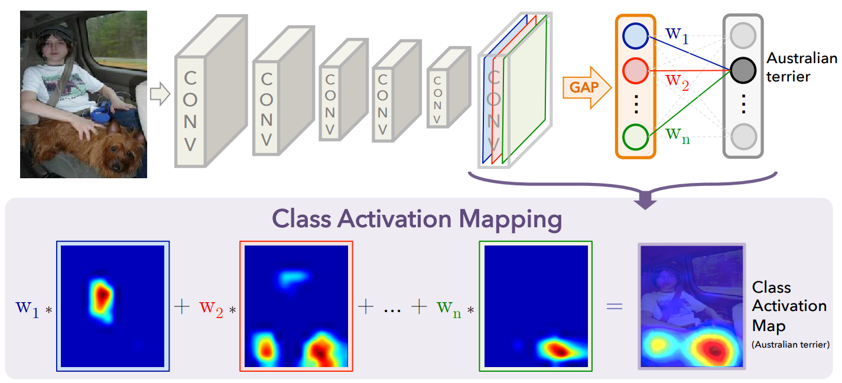
</div>

Ideea din spatele CAM este destul de simplă - explicația pentru orice intrare este o combinație liniară a hărților de activare (feature maps) dintr-un strat țintă (de obicei ultimul strat convoluțional). Fiecare feature map din activările alese este scalat cu un scor care ar trebui să fie reprezentativ pentru cât de important a fost aceasta în raport cu predicția finală (feature map-urile mai importante ar trebui să aibă scoruri mai mari).
Prin însumarea hărților de activare scalate, obținem un heatmap cu un singur canal care evidențiază zonele semnificative din activările rezultate. Pentru a aduce acest heatmap în spațiul original al pixelilor, trebuie să redimensionăm explicația astfel încât să se potrivească dimensiunii intrării, deoarece, prin design, rezoluția sa spațială este limitată la cea a activărilor stratului țintă.

În cazul **Grad-CAM**, scorurile sunt calculate ca media globală a gradientului corespunzător stratului țintă. Astfel, **Grad-CAM** necesită doar un singur pas forward și backward pentru a genera explicația pentru un batch de itrări.

In [ ]:
class GradCAM:

    def __init__(self, model: nn.Module, target_layer: nn.Module, device: torch.device) -> None:

        self.model = model
        self.device = device
        self.activations_and_grads = ActivationsAndGradients(model, target_layer)

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()

    def normalize(self, cam: np.ndarray) -> np.ndarray:
        return np.float32([(x - x.min()) / (x.max() - x.min() + 1e-7) for x in cam])

    def scale(self, cam: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
        return np.float32([cv2.resize(x, target_size) for x in cam])

    def __call__(self, input_tensor: Tensor, class_idx: Optional[int] = None) -> np.ndarray:
        """
        Compute Grad-CAM heatmap for a given input Tensor

        :param input_tensor: Input of shape (1, C, H, W).
        :param class_idx: Target class index (default: predicted class).

        :return: Heatmap of shape (1, H, W).
        """

        # Get the activations and gradients by running the input through the model
        # and running a backward pass (for the gradients)
        input_tensor = input_tensor.to(self.device)
        output = self.activations_and_grads(input_tensor)

        if class_idx is None:
            class_idx = np.argmax(output.cpu().data.numpy(), axis=-1)

        ## TODO 6: Clear previous gradients and compute loss for target class.
        self.model.zero_grad()
        loss = output[:, class_idx].sum()

        ## TODO 7: Run backward pass to compute the gradients
        loss.backward()


        # Retrieve activations and gradients from the hooks.
        activations = self.activations_and_grads.activations.cpu().data.numpy()

        ## TODO 8: Uncomment after running the backward pass
        gradients = self.activations_and_grads.gradients.cpu().data.numpy()


        ## TODO 9: Compute Grad-CAM weights as the global mean of the gradients.
        weights = np.mean(gradients, axis=(2, 3))

        ## TODO 10: Construct the weighted sum of activations.
        ## The cam explanation is the sum of the activations scaled by the corresponding weights
        cam = torch.zeros(activations.shape[0], *activations.shape[2:])
        for i, (weight, activation) in enumerate(zip(weights, activations)):
            weighted_activations = weight[:, None, None] * activation
            cam[i, :, :] = torch.from_numpy(np.sum(weighted_activations, axis=0))


        # Post process the heatmap
        cam = np.maximum(cam, 0)   # Only keep positive influences
        cam = self.normalize(cam)  # Normalize to [0, 1] range
        cam = self.scale(cam, input_tensor.shape[-2:])  # Scale to the size of the input

        return cam

# Găsirea zonelor din imagine unde modelul se uită

## Încărcarea unui exemplu pentru a fi explicat

In [ ]:
image = Image.open('dog_cat.png')
input_tensor = preprocess_image(image)
image

## Grad-CAM

In [ ]:
grad_cam = GradCAM(model, target_layer, device=device)

In [ ]:
heatmap = grad_cam(input_tensor)  # output is of shape (1, 224, 224)
display(image, heatmap)  # Explanation for class `bull mastiff`

In [ ]:
heatmap = grad_cam(input_tensor, class_idx=282)
display(image, heatmap)  # Explanation for class `tiger cat`